In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.display import Video

import os

from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
from moviepy import editor
import tqdm
from homan.datasets import epichoa
import odlib
import pickle
from PIL import Image
import pandas as pd
import numpy as np
import odlib
odlib.setup()

class EpicHO(object):
    def __init__(self,
                 train_pkl_path='/media/deepthought/DATA/Zhifan/epic-kitchens-100-annotations/EPIC_100_train.pkl',
                 rgb_frames_root='/media/eve/DATA2/Datasets/epic-100/rgb_frames/',
                 hoa_root='/home/skynet/Zhifan/datasets/epic/hoa/',
                 valid_vids_path='/home/deepthought/Zhifan/allVideos.xlsx',
                ):
        self.rgb_frames_root = rgb_frames_root
        self.hoa_root = hoa_root

        with open(train_pkl_path, 'rb') as fp:
            self.train_meta = pickle.load(fp)
            
        valid_vids = pd.read_excel(valid_vids_path)
        self.train_meta = self.train_meta[self.train_meta.video_id.isin(valid_vids['Unnamed: 0'])]
            
    def select_object_video(self, obj='plate', index=0):
        obj_df = self.train_meta[self.train_meta['noun'].isin([obj])]
        if index < 0:
            if len(obj_df) <= 0:
                raise ValueError(f"{obj} has no valid videos")
            index = np.random.choice(len(obj_df))
        obj_df_i = obj_df.iloc[index]
        ret =  (obj_df_i.participant_id,
                obj_df_i.video_id,
                obj_df_i.start_frame,
                obj_df_i.stop_frame)
        print(f"choose {obj} PID={ret[0]} VID={ret[1]}")
        return ret # pid, vid, st, ed
           
    def generate_object_video(self, obj='plate', index=0, cache=False):
        pid, vid, st, ed = self.select_object_video(obj, index)
        if cache:
            self._vid = vid
            self._st = st
        return self.make_video(pid, vid, st, ed)
    
    def make_frame(self,
                   frame_df,
                   participant_id,
                   video_id,
                   frame):
        img = Image.open( f'{self.rgb_frames_root}/{participant_id}/{video_id}/frame_{frame:010}.jpg' )
        img = np.asarray(img)
        l = np.asarray(frame_df['left'])
        r = np.asarray(frame_df['right'])
        t = np.asarray(frame_df['top'])
        b = np.asarray(frame_df['bottom'])
        boxes = np.vstack([l, t, r, b]).T / [1920, 1080, 1920, 1080] * [456, 256, 456, 256]
        return odlib.draw_bboxes_image_array(img, boxes)

    def make_video(self,
                   participant_id,
                   video_id, 
                   start_frame,
                   end_frame,
                   max_frames=512):
        """
        Return:
            list of numpy array (H, W, 3)
        """
        hoa_df = epichoa.load_video_hoa(video_id, self.hoa_root)
        video_df = hoa_df[hoa_df['video_id'] == video_id]
        # _frames = video_df['frame']
        # st, ed = min(_frames), max(_frames)
        end_frame = min(start_frame + max_frames, end_frame)
        frames = []
        for i in tqdm.trange(start_frame, end_frame):
            frame = self.make_frame(video_df[video_df['frame']==i], participant_id, video_id, i)
            frames.append(np.asarray(frame))
        # frames = np.asarray(frames)
        return frames    

eho = EpicHO()

In [64]:
frames = eho.generate_object_video(index=-1, cache=True)

choose plate PID=P03 VID=P03_17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 135.25it/s]


In [71]:
clip = editor.ImageSequenceClip(frames, fps=25)
clip.write_videofile('tmp/output.mp4', logger=None)

In [41]:
obj_list = ['bottle', 'jug', 'pitcher', 'plate', 'cup', 'phone', 'can']
for obj in obj_list:
    for i in range(5):
        try:
            frames = eho.generate_object_video(obj=obj, index=-1, cache=True)
            clip = editor.ImageSequenceClip(frames, fps=25)
            clip.write_videofile(f'tmp/inspect/{obj}_{eho._vid}_{eho._st}.mp4')
        except ValueError as e:
            print(e)


choose bottle PID=P12 VID=P12_04


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 43.63it/s]


Moviepy - Building video tmp/inspect/bottle_P12_04_1611.mp4.
Moviepy - Writing video tmp/inspect/bottle_P12_04_1611.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/bottle_P12_04_1611.mp4
choose bottle PID=P12 VID=P12_04


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:01<00:00, 205.23it/s]


Moviepy - Building video tmp/inspect/bottle_P12_04_1740.mp4.
Moviepy - Writing video tmp/inspect/bottle_P12_04_1740.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/bottle_P12_04_1740.mp4
choose bottle PID=P24 VID=P24_05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.55it/s]


Moviepy - Building video tmp/inspect/bottle_P24_05_45371.mp4.
Moviepy - Writing video tmp/inspect/bottle_P24_05_45371.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/bottle_P24_05_45371.mp4
choose bottle PID=P01 VID=P01_05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:03<00:00, 40.31it/s]


Moviepy - Building video tmp/inspect/bottle_P01_05_33876.mp4.
Moviepy - Writing video tmp/inspect/bottle_P01_05_33876.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/bottle_P01_05_33876.mp4
choose bottle PID=P24 VID=P24_08


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.22it/s]


Moviepy - Building video tmp/inspect/bottle_P24_08_51978.mp4.
Moviepy - Writing video tmp/inspect/bottle_P24_08_51978.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/bottle_P24_08_51978.mp4
choose jug PID=P06 VID=P06_05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 134.39it/s]


Moviepy - Building video tmp/inspect/jug_P06_05_72075.mp4.
Moviepy - Writing video tmp/inspect/jug_P06_05_72075.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/jug_P06_05_72075.mp4
choose jug PID=P06 VID=P06_05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 134.59it/s]


Moviepy - Building video tmp/inspect/jug_P06_05_72075.mp4.
Moviepy - Writing video tmp/inspect/jug_P06_05_72075.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/jug_P06_05_72075.mp4
choose jug PID=P06 VID=P06_05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 134.42it/s]


Moviepy - Building video tmp/inspect/jug_P06_05_72075.mp4.
Moviepy - Writing video tmp/inspect/jug_P06_05_72075.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/jug_P06_05_72075.mp4
choose jug PID=P06 VID=P06_05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 134.52it/s]


Moviepy - Building video tmp/inspect/jug_P06_05_72075.mp4.
Moviepy - Writing video tmp/inspect/jug_P06_05_72075.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/jug_P06_05_72075.mp4
choose jug PID=P06 VID=P06_05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 134.55it/s]


Moviepy - Building video tmp/inspect/jug_P06_05_72075.mp4.
Moviepy - Writing video tmp/inspect/jug_P06_05_72075.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/jug_P06_05_72075.mp4
pitcher has no valid videos
pitcher has no valid videos
pitcher has no valid videos
pitcher has no valid videos
pitcher has no valid videos
choose plate PID=P01 VID=P01_09


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 314/314 [00:09<00:00, 32.64it/s]


Moviepy - Building video tmp/inspect/plate_P01_09_190375.mp4.
Moviepy - Writing video tmp/inspect/plate_P01_09_190375.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/plate_P01_09_190375.mp4
choose plate PID=P26 VID=P26_02


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 48.99it/s]


Moviepy - Building video tmp/inspect/plate_P26_02_9684.mp4.
Moviepy - Writing video tmp/inspect/plate_P26_02_9684.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/plate_P26_02_9684.mp4
choose plate PID=P13 VID=P13_10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 59.80it/s]


Moviepy - Building video tmp/inspect/plate_P13_10_407.mp4.
Moviepy - Writing video tmp/inspect/plate_P13_10_407.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/plate_P13_10_407.mp4
choose plate PID=P08 VID=P08_21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:02<00:00, 38.10it/s]


Moviepy - Building video tmp/inspect/plate_P08_21_13233.mp4.
Moviepy - Writing video tmp/inspect/plate_P08_21_13233.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/plate_P08_21_13233.mp4
choose plate PID=P03 VID=P03_04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.48it/s]


Moviepy - Building video tmp/inspect/plate_P03_04_67903.mp4.
Moviepy - Writing video tmp/inspect/plate_P03_04_67903.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/plate_P03_04_67903.mp4
choose cup PID=P23 VID=P23_02


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 34.72it/s]


Moviepy - Building video tmp/inspect/cup_P23_02_92204.mp4.
Moviepy - Writing video tmp/inspect/cup_P23_02_92204.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/cup_P23_02_92204.mp4
choose cup PID=P01 VID=P01_03


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 62.54it/s]


Moviepy - Building video tmp/inspect/cup_P01_03_3045.mp4.
Moviepy - Writing video tmp/inspect/cup_P01_03_3045.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/cup_P01_03_3045.mp4
choose cup PID=P04 VID=P04_13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:04<00:00, 42.37it/s]


Moviepy - Building video tmp/inspect/cup_P04_13_10393.mp4.
Moviepy - Writing video tmp/inspect/cup_P04_13_10393.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/cup_P04_13_10393.mp4
choose cup PID=P02 VID=P02_01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 54.58it/s]


Moviepy - Building video tmp/inspect/cup_P02_01_7291.mp4.
Moviepy - Writing video tmp/inspect/cup_P02_01_7291.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/cup_P02_01_7291.mp4
choose cup PID=P01 VID=P01_09


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 41.26it/s]


Moviepy - Building video tmp/inspect/cup_P01_09_6796.mp4.
Moviepy - Writing video tmp/inspect/cup_P01_09_6796.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/cup_P01_09_6796.mp4
phone has no valid videos
phone has no valid videos
phone has no valid videos
phone has no valid videos
phone has no valid videos
choose can PID=P03 VID=P03_04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.54it/s]


Moviepy - Building video tmp/inspect/can_P03_04_916.mp4.
Moviepy - Writing video tmp/inspect/can_P03_04_916.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/can_P03_04_916.mp4
choose can PID=P12 VID=P12_02


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:06<00:00, 35.05it/s]


Moviepy - Building video tmp/inspect/can_P12_02_62341.mp4.
Moviepy - Writing video tmp/inspect/can_P12_02_62341.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/can_P12_02_62341.mp4
choose can PID=P02 VID=P02_09


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 36.59it/s]


Moviepy - Building video tmp/inspect/can_P02_09_42615.mp4.
Moviepy - Writing video tmp/inspect/can_P02_09_42615.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/can_P02_09_42615.mp4
choose can PID=P12 VID=P12_02


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:04<00:00, 40.50it/s]


Moviepy - Building video tmp/inspect/can_P12_02_14704.mp4.
Moviepy - Writing video tmp/inspect/can_P12_02_14704.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/can_P12_02_14704.mp4
choose can PID=P03 VID=P03_04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 42.91it/s]


Moviepy - Building video tmp/inspect/can_P03_04_834.mp4.
Moviepy - Writing video tmp/inspect/can_P03_04_834.mp4



Moviepy - Done !
Moviepy - video ready tmp/inspect/can_P03_04_834.mp4


# Analysis set

In [199]:
import epylab as pylab
import dask.dataframe as dd
import pandas as pd

## Loading -> 67217

In [227]:
annot_df = '/home/skynet/Zhifan/data/epic/EPIC_100_train.csv'
annot_df = pd.read_csv(annot_df)
print(len(annot_df))

annot_df = annot_df[annot_df['narration_timestamp'].notnull()]

67217


## Filter no seg 
- by vid: 9562
- by requiring (st, ed) be included in gt-pair: 8633

In [206]:
from pathlib import Path
import glob, json, tqdm
all_segs = '/home/skynet/Zhifan/data/more_segs'
data_root = Path(all_segs)
pid_set = set()
vid_set = set()
vid_map = dict()
for fname in tqdm.tqdm(glob.glob(str(data_root/"*.json"))):
    with open(fname) as fp:
        data = json.load(fp)
    for ann in data:
        for doc in ann['documents']:
            vid = doc['directory'].split('/')[0]
            pid = vid[:3]
            frame_id = int(doc['name'].split('.')[0].split('_')[-1])
            pid_set.add(pid)
            vid_set.add(vid)
            if vid not in vid_map:
                vid_map[vid] = [frame_id]
            else:
                vid_map[vid].append(frame_id)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:13<00:00,  4.16it/s]


In [228]:
import bisect
annot_df = annot_df[annot_df.video_id.isin(list(vid_map.keys()))]
print(len(annot_df))
for k in vid_map.keys():
    vid_map[k] = sorted(vid_map[k])
keep = []
for i, annot in (annot_df.iterrows()):
    vid = annot.video_id
    st, ed = annot.start_frame, annot.stop_frame
    L = vid_map[vid]
    l = bisect.bisect_left(L, st)
    if l == 0:
        continue
    r = bisect.bisect_right(L, ed)
    if r == len(L):
        continue
    keep.append(i)

annot_df = annot_df.loc[keep, :]
print(len(annot_df))

9562
8633


In [215]:
annot_df.to_json('/home/skynet/Zhifan/epic_clip_viewer/data/EPIC100_8k.json', orient='records')

## Filter nouns -> 359

In [ ]:
set(annot_df.noun)

In [245]:
print(len(annot_df[annot_df.noun.isin(nouns)]))

578


In [244]:
nouns=[
        "can",
        "cup", "mug", # mug glass
        "plate",
        "bottle", "bottle:oil", "sauce:bottle", "bottle:soy sauce", "bottle:water",
        "jug",
    "bowl",
    # "pitcher",
]

annot_df = annot_df[annot_df.noun.isin(nouns)]
print(len(annot_df))

578


In [236]:
annot_df.to_json('/home/skynet/Zhifan/epic_clip_viewer/data/filtered_300.json', orient='records')

(array([24., 17., 15., 20., 14., 27., 47., 98., 52., 45.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

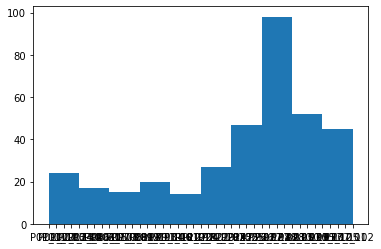

In [166]:
pylab.hist(annot_df.video_id)